In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
from analysis_functions import *
import uncertainties.unumpy as unp
from uncertainties import ufloat

In [2]:
results_folder_path = "/Users/colinweaver/Documents/PTTEP/Results/"

data_300K_run4_path = "08.29/run_1_09h53"

data_300K_run2 = "/Users/colinweaver/Documents/PTTEP/Results/09.22/run_1_10h39"
data_300K_run1 = "/Users/colinweaver/Documents/PTTEP/Results/09.10/run_1_08h30"
data_300K_run3 = "/Users/colinweaver/Documents/PTTEP/Results/09.11/run_1_09h38"
data_300K_run4 = results_folder_path + data_300K_run4_path

temperature_C = 500 # temperature in Celsius
e = 0.00088 # sample thickness in meters measured

In [3]:
# Load data
t, df = load_downstream_data(data_300K_run4 + "/pressure_gauge_data.csv")

V_Baratron_downstream = df["Baratron626D_1T_Voltage_V"].to_numpy(dtype=float)
V_Wasp_downstream = df["WGM701_Voltage_V"].to_numpy(dtype=float)
V_Baratron_upstream = df["Baratron626D_1KT_Voltage_V"].to_numpy(dtype=float)
V_Wasp_upstream = df["CVM211_Voltage_V"].to_numpy(dtype=float)

t_0 = 0

P_Wasp_downstream = voltage_to_torr_wasp_downstream(V_Wasp_downstream)
P_Baratron_upstream = voltage_to_torr_baratron(V_Baratron_upstream)

P_up = average_pressure_after_increase(t, P_Baratron_upstream)  # convert Torr to Pa


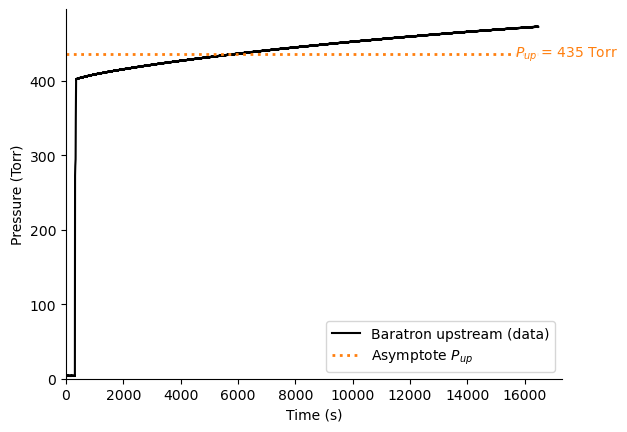

In [4]:
plt.figure()
ax = plt.gca()

# Plot upstream Baratron pressure data
ax.plot(t, P_Baratron_upstream, color="black", linewidth=1.5, label="Baratron upstream (data)")

# Draw horizontal asymptote at P_up
ax.hlines(P_up, xmin=float(t[0]), xmax=float(t[-1]),
          linestyles=":", linewidth=2, color="C1", label="Asymptote $P_{up}$")

# Annotate the P_up value on the right-hand side
x_annot = t[-1] - 0.05 * (t[-1] - t[0])  # slightly inset from right edge
ax.text(x_annot, P_up,
        f"$P_{{up}}$ = {P_up:.3g} Torr",
        va="center", ha="left",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.8),
        color="C1")

# Style axes
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pressure (Torr)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend()

# Save or show
# plt.savefig("baratron_upstream_asymptote.png", dpi=300, bbox_inches="tight")
plt.show()

[0.0000000e+00 5.1800000e-01 1.0310000e+00 ... 1.6471114e+04 1.6471627e+04
 1.6472162e+04]
[1.72176388e-05 1.72427045e-05 1.72552510e-05 ... 2.42950502e+00
 2.41892513e+00 2.42244663e+00]
asymptote x-intercept: 6477.607090203612


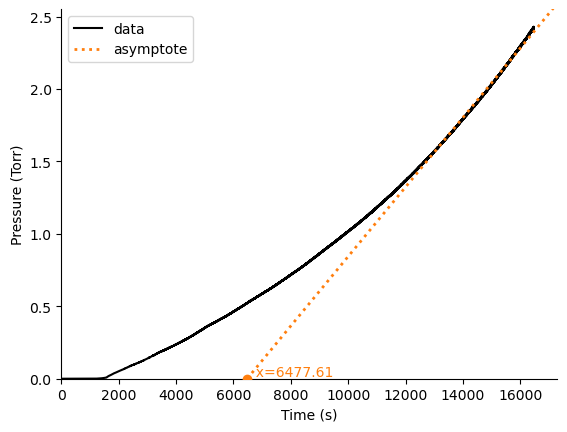

In [5]:
plt.figure()
ax = plt.gca()
ax.plot(t, P_Wasp_downstream, color="black", label="data")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pressure (Torr)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

print(t)
print(P_Wasp_downstream)

# Fit asymptote and plot as dotted line down to its x-axis crossing

slope, intercept, start_idx = fit_linear_asymptote(t, P_Wasp_downstream)
# compute x where asymptote crosses y=0: 0 = slope*x + intercept
if abs(slope) < 1e-12:
    # slope too small to find a meaningful intercept
    raise ValueError("slope too small")
x_cross = -intercept / slope
print(f"asymptote x-intercept: {x_cross}")

# draw asymptote from its x-intercept up to the end of the data
x_span = t[-1] - t[0] if t[-1] != t[0] else 1.0
x_end = t[-1] + 0.2 * x_span
x_start = x_cross
# ensure we create an array in increasing order for plotting
if x_start <= x_end:
    x_ext = np.linspace(x_start, x_end, 2)
else:
    x_ext = np.linspace(x_end, x_start, 2)
y_ext = slope * x_ext + intercept
ax.plot(x_ext, y_ext, linestyle=":", color="C1", linewidth=2, label="asymptote")

# mark crossing on the x-axis and annotate
if np.isfinite(x_cross):
    ax.scatter([x_cross], [0], color="C1", zorder=5)
    ax.text(x_cross, 0, f"  x={x_cross:.2f}", va="bottom", color="C1")
ax.legend()


plt.show()

# plt.savefig("asymptote_fit.png", dpi=300, bbox_inches="tight")


In [6]:
# Using timelag to calculate D_eff
tau_l = x_cross - t_0
D_eff = e**2 / (6 * tau_l)

print(f"Effective diffusion coefficient: D_eff = {D_eff:.2e} m^2/s")

Effective diffusion coefficient: D_eff = 1.99e-11 m^2/s


In [7]:
# Using Flux to calculate permeability
temperature_K = temperature_C + 273.15
R = 8.314 # J/(mol*K)

dPdt = slope * 133.3 # convert Torr/s to Pa/s
V = 7.9e-5
# V = ufloat(7.9e-5, 9e-6) # m^3, volume of downstream chamber
d_sample = 0.0155 # diameter of fitting on sample in meters
A = 1/4 * np.pi * (d_sample)**2 # m^2
J = dPdt*V / (R*temperature_K*A) * 6.022*10**23 # H/(m^2*s)

Perm = J*e / (P_up*133.3)

print(f"Permeability: Phi = {Perm:.2e}")

Permeability: Phi = 1.90e+10


In [8]:
import csv

# Fill in
material = "316l_steel" # same format as htm


outdir = "results/figs"
os.makedirs(outdir, exist_ok=True)   # Create folders if not exist
csv_filename = os.path.join(outdir, f"{material}_diffusivities.csv")

write_run_to_csv(csv_filename, data_300K_run4_path, material, temperature_K, D_eff, Perm)